In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,classification_report,roc_curve,auc,confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Reading CSV Files of Training and Testing Datasets
df_train=pd.read_csv("/content/drive/MyDrive/NAD-Datasets/NSL-KDD-Train.csv")
df_test=pd.read_csv("/content/drive/MyDrive/NAD-Datasets/NSL-KDD-Test.csv")

In [5]:
# Dataset URL - https://www.kaggle.com/datasets/sanketrai/nslkdd-dataset
#               https://www.kaggle.com/code/kapusharinka/network-anomaly-detection
# Unseen Data - https://www.kaggle.com/datasets/deepthisudharsan/network-anomaly-dataset

In [6]:
# Size of Train and Test Data
df_train.shape,df_test.shape

((125973, 42), (22544, 42))

In [7]:
# Concatenate Train and Test DataFrames
df=pd.concat([df_train,df_test],ignore_index=True)

In [8]:
# Size of Dataset
df.shape

(148517, 42)

In [9]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [10]:
# Check Value Counts of 'land','urgent','num_failed_logins','num_outbound_cmds' Features
df[['land','urgent','num_failed_logins','num_outbound_cmds']].value_counts()

land  urgent  num_failed_logins  num_outbound_cmds
0     0       0                  0                    147868
              1                  0                       577
1     0       0                  0                        32
0     1       0                  0                         9
      0       2                  0                         8
              3                  0                         8
      2       0                  0                         7
      0       4                  0                         4
              5                  0                         1
      1       2                  0                         1
      3       0                  0                         1
              2                  0                         1
Name: count, dtype: int64

In [11]:
# The Columns 'land','urgent','num_failed_logins','num_outbound_cmds' have mostly Zero Values so we can Drop these Columns
df.drop(['land','urgent','num_failed_logins','num_outbound_cmds'],axis=1,inplace=True)

In [12]:
# Check for Missing Values, If Present We have to Perform Imputation
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148517 entries, 0 to 148516
Data columns (total 38 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     148517 non-null  int64  
 1   protocol_type                148517 non-null  object 
 2   service                      148517 non-null  object 
 3   flag                         148517 non-null  object 
 4   src_bytes                    148517 non-null  int64  
 5   dst_bytes                    148517 non-null  int64  
 6   wrong_fragment               148517 non-null  int64  
 7   hot                          148517 non-null  int64  
 8   logged_in                    148517 non-null  int64  
 9   num_compromised              148517 non-null  int64  
 10  root_shell                   148517 non-null  int64  
 11  su_attempted                 148517 non-null  int64  
 12  num_root                     148517 non-null  int64  
 13 

In [13]:
df.rename(columns={'class':'attack'},inplace=True)

In [14]:
# Drop Duplicate Records
df.drop_duplicates(inplace=True)

[Text(0, 0, 'Normal'), Text(1, 0, 'Anomaly')]

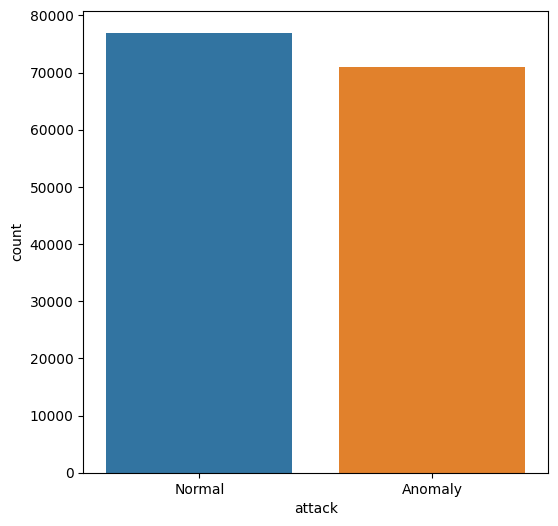

In [15]:
# Count Plot for Attack Class Label
plt.figure(figsize=(6,6))
ax=sns.countplot(x='attack',data=df,hue='attack',legend=False)
ax.set_xticks([0,1])
ax.set_xticklabels(['Normal','Anomaly'])

In [16]:
# Check for Categorical dtype Columns
df.select_dtypes(exclude=[np.number])

,protocol_type,service,flag,attack
0,tcp,ftp_data,SF,normal
1,udp,other,SF,normal
2,tcp,private,S0,anomaly
3,tcp,http,SF,normal
4,tcp,http,SF,normal
...,...,...,...,...
148510,tcp,smtp,SF,anomaly
148512,tcp,smtp,SF,normal
148513,tcp,http,SF,normal
148514,tcp,http,SF,anomaly


In [17]:
# Encode the Columns with Categorical dtype
service_encoder=None
labels=['protocol_type','service','flag','attack']
for label in labels:
  le=LabelEncoder()
  df[label]=le.fit_transform(df[label])
  if label=="service":
    service_encoder=le

In [18]:
# Target Class Label Counts after LabelEncoding
'''
  0: 'Anomaly',
  1: 'Normal'
'''
df['attack'].value_counts()

,count
attack,
1,76967
0,70921


<Axes: >

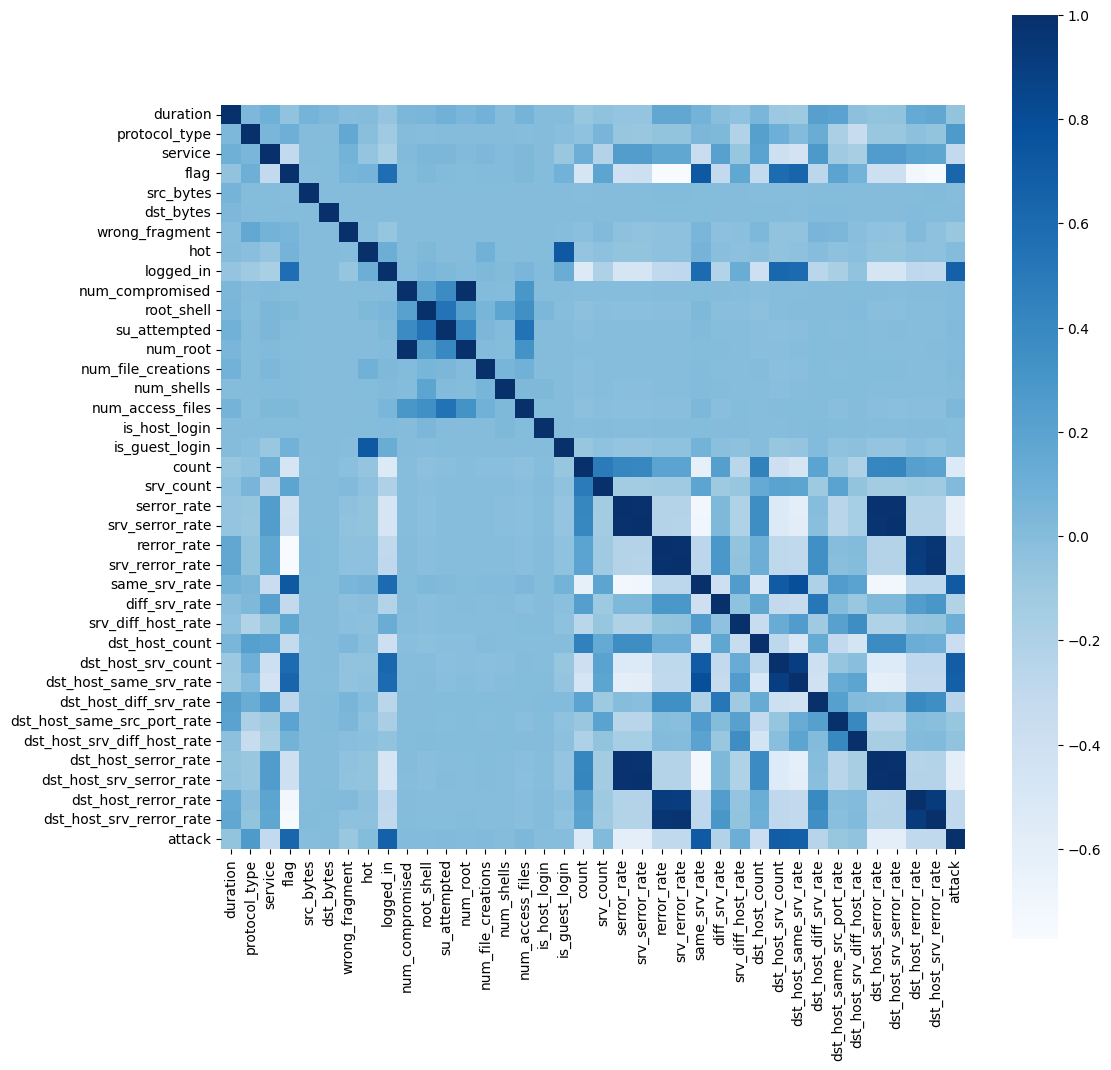

In [19]:
# HeatMap to Understand the Correlation Between all Features
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(),cbar=True,square=True,annot_kws={'size':10},cmap='Blues')

In [20]:
# Seperate Target label from Data
x=df.drop(columns='attack',axis=1)
y=df.iloc[:,37]
feature_names=x.columns

In [21]:
# Standardizing the Features
scaler=StandardScaler()
x=scaler.fit_transform(x)

In [22]:
# Split the Data into Training and Testing Data
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,stratify=y)

In [23]:
# Define Hyperparameter Grids for Each Model
param_grids={
    'DecisionTreeClassifier':{
        'criterion':['gini','entropy'],
        'max_depth':[None,20,30]
    },
    'RandomForestClassifier':{
        'n_estimators':[50,100],
        'max_depth':[10,20,30]
    },
    'AdaBoostClassifier':{
        'n_estimators':[100,150],
        'learning_rate':[0.1,0.2,0.3]
    },
    'XGBClassifier':{
        'learning_rate':[0.01,0.1,0.2],
        'max_depth':[3,5,7],
    },
    'LGBMClassifier':{
        'learning_rate':[0.01,0.1,0.2],
        'n_estimators':[50,100,150]
    }
}

# Define Models
models=[
    ('DecisionTreeClassifier',DecisionTreeClassifier()),
    ('RandomForestClassifier',RandomForestClassifier()),
    ('AdaBoostClassifier',AdaBoostClassifier()),
    ('XGBClassifier',XGBClassifier()),
    ('LGBMClassifier',LGBMClassifier(verbosity=-1))
]

In [24]:
# Perform RandomizedSearchCV for Each Model
best_estimators={}
for model_name,model in models:
    print(f"Tuning {model_name}...")
    param_grid=param_grids[model_name]
    # Initialize RandomizedSearchCV
    search=RandomizedSearchCV(
        model,param_distributions=param_grid,
        scoring='accuracy'
    )
    # Fit the Model with RandomizedSearchCV
    search.fit(x_train,y_train)
    best_estimators[model_name]=search.best_estimator_
    print(f"Best parameters for {model_name} : {search.best_params_}")
    print(f"Best score for {model_name} : {search.best_score_}")

Tuning DecisionTreeClassifier...
Best parameters for DecisionTreeClassifier : {'max_depth': 20, 'criterion': 'entropy'}
Best score for DecisionTreeClassifier : 0.9944913299380547
Tuning RandomForestClassifier...
Best parameters for RandomForestClassifier : {'n_estimators': 50, 'max_depth': 30}
Best score for RandomForestClassifier : 0.9957264986512951
Tuning AdaBoostClassifier...
Best parameters for AdaBoostClassifier : {'n_estimators': 150, 'learning_rate': 0.3}
Best score for AdaBoostClassifier : 0.9670651759316607
Tuning XGBClassifier...
Best parameters for XGBClassifier : {'max_depth': 7, 'learning_rate': 0.2}
Best score for XGBClassifier : 0.9963215444444442
Tuning LGBMClassifier...
Best parameters for LGBMClassifier : {'n_estimators': 100, 'learning_rate': 0.2}
Best score for LGBMClassifier : 0.9962313828750876


In [25]:
# Create Instance for LGBMClassifier (Best Model Choosen according to Hyperparameter Tuning)
clf=LGBMClassifier(n_estimators=100,learning_rate=0.2)

# Train the Initial Model
clf.fit(x_train,y_train)

# Evaluate Initial Model Performance on Test Set
y_pred=clf.predict(x_test)

# Print the Accuracy on Test Data
initial_accuracy=accuracy_score(y_test,y_pred)
print(f"Initial Accuracy on Test Set : {initial_accuracy:.5f}")

Initial Accuracy on Test Set : 0.99646


In [26]:
# Feature Selection
# Get Feature Importances
feature_importances=clf.feature_importances_

# Create DataFrame to Show Feature Importances
feature_importances_df=pd.DataFrame({'Feature':feature_names,'Importance':feature_importances})

# Sort Features by Importance
feature_importances_df=feature_importances_df.sort_values(by='Importance',ascending=False)

# Manually Select Top 6 Features Based on Importance
selected_features=feature_importances_df['Feature'][:3].values
print("Selected Features : ",selected_features)

Selected Features :  ['src_bytes' 'service' 'dst_bytes']


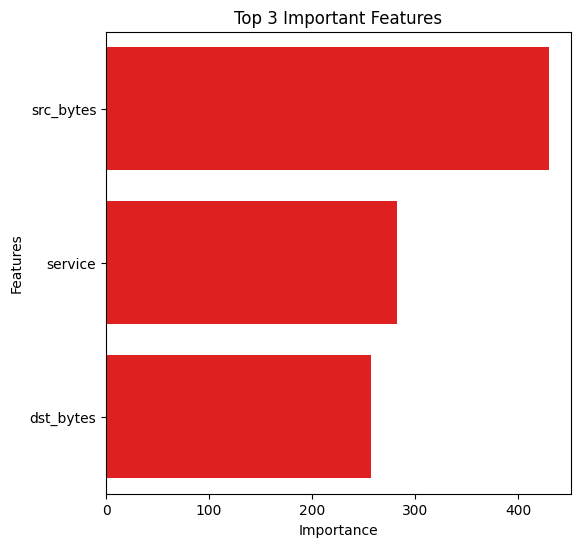

In [27]:
# Plot Important Features
plt.figure(figsize=(6,6))
sns.barplot(x='Importance',y='Feature',data=feature_importances_df.head(3),color="r")
plt.title('Top 3 Important Features')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

<Axes: >

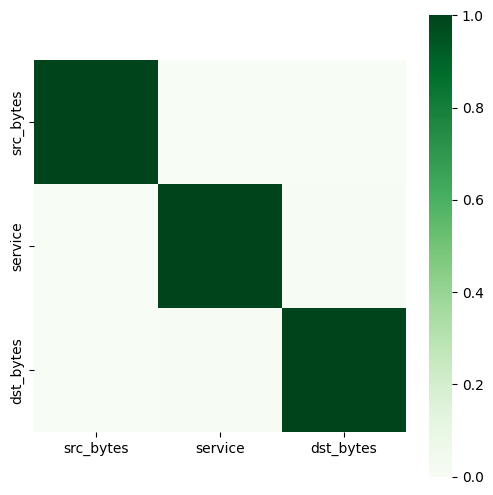

In [28]:
# HeatMap to Understand the Correlation Between Selected Features
plt.figure(figsize=(6,6))
sns.heatmap(df.drop(columns="attack",axis=1)[selected_features].corr(),cbar=True,square=True,annot_kws={'size':10},cmap='Greens')

In [29]:
# Standardize Feature Selected Data
x=scaler.fit_transform(df[selected_features])

In [30]:
# Split the Data into Training and Testing Data
x_train_reduced,x_test_reduced,y_train,y_test=train_test_split(x,y,test_size=0.25,stratify=y)

In [31]:
# Train a New LGBMClassifier with Reduced Features
classifier=LGBMClassifier(n_estimators=100,learning_rate=0.2)
classifier.fit(x_train_reduced,y_train)

# Evaluate the Reduced Model on Test Set
y_pred_reduced=classifier.predict(x_test_reduced)
accuracy=accuracy_score(y_test,y_pred_reduced)

# Print the Accuracy after Feature Selection
print(f"Selected Features : {selected_features}")
print(f"Best Accuracy on Test Set with {len(selected_features)} Features : {accuracy:.5f}")

Selected Features : ['src_bytes' 'service' 'dst_bytes']
Best Accuracy on Test Set with 3 Features : 0.97950


In [32]:
# Classification Report
print(classification_report(y_test,y_pred_reduced))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     17730
           1       0.97      0.99      0.98     19242

    accuracy                           0.98     36972
   macro avg       0.98      0.98      0.98     36972
weighted avg       0.98      0.98      0.98     36972



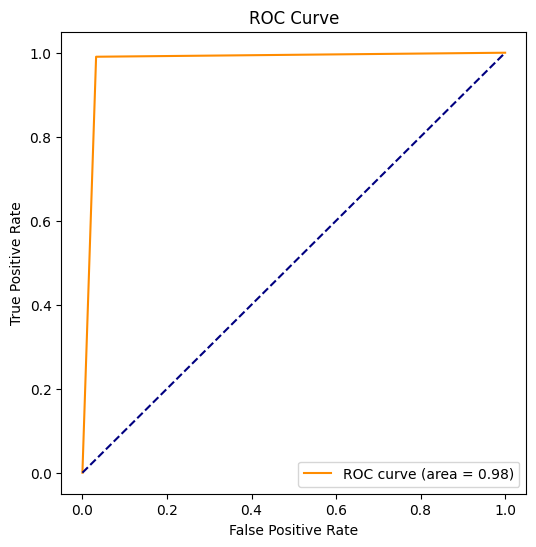

In [33]:
# Receiver Operating Characteristic Curve (ROC Curve)
fpr,tpr,thresholds=roc_curve(y_test,y_pred_reduced)
roc_auc=auc(fpr,tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,color='darkorange',label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1],[0,1],color='navy',linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

[Text(0, 0.5, 'Anomaly'), Text(0, 1.5, 'Normal')]

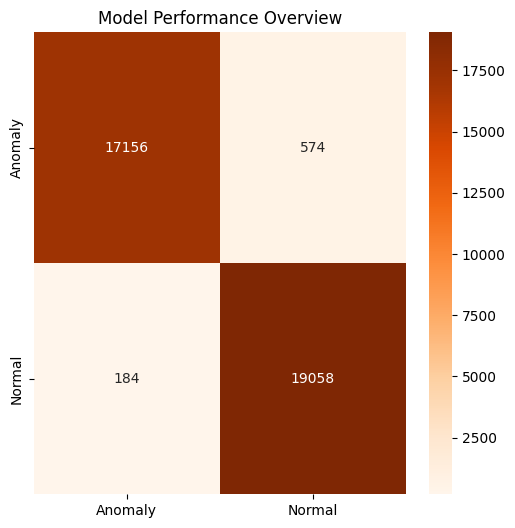

In [34]:
# Visualize Confusion Matrix
cm=confusion_matrix(y_test,y_pred_reduced)
plt.figure(figsize=(6,6))
plt.title("Model Performance Overview")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax=sns.heatmap(cm,annot=True,fmt="d",cmap="Oranges",cbar=True)
ax.set_xticks([0.5,1.5])
ax.set_yticks([0.5,1.5])
ax.set_xticklabels(['Anomaly','Normal'])
ax.set_yticklabels(['Anomaly','Normal'])

In [35]:
df[np.append(selected_features,'attack')].tail(30)

,src_bytes,service,dst_bytes,attack
148484,235,24,892,1
148485,0,4,0,0
148486,126,60,174,0
148487,115,44,0,1
148488,0,24,0,0
148489,322,24,396,1
148490,0,60,44,0
148491,295,24,757,1
148492,0,60,15,0
148493,0,49,0,0


In [36]:
# Evaluate on Sample Input
input=[54540,24,8314]
input_df=pd.DataFrame([input],columns=selected_features)
input_df=scaler.transform(input_df)
prediction=classifier.predict(input_df)
mapper={0:'Anomaly',1:'Normal'}
print("Predicted Class Label :",mapper[prediction[0]])

Predicted Class Label : Anomaly


In [37]:
# Saving the Trained Model, Label Encoder and Scaler Object
pickle.dump(classifier,open('Trained-Model.pkl','wb'))
pickle.dump(service_encoder,open('Service-Label-Encoder.sav','wb'))
pickle.dump(scaler,open('Scaler.sav','wb'))